In [50]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.widgets import *
from fastai.callbacks.hooks import *
current_palette = sns.color_palette('GnBu_d',7)
sns.set_palette(current_palette)

In [2]:
# Indicate the paths for the two datasets (.csv and images)
path = '../input/fer2013-images/images/images_fer2013/Training'
path2 = '../input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013/fer2013/fer2013.csv'
wd = '/kaggle/working' # Create a working directory to save files created

# Create ImageDataBunch (from fastai library)
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), bs=128)

print(f'Number of images:\nTraining: {len(data.train_ds)}, Validation: {len(data.valid_ds)}')

Number of images:
Training: 22968, Validation: 5741


### *CNN from Scratch*

In [5]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [6]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [7]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [8]:
model_own = nn.Sequential(
    conv_and_res(3, 8), #24
    conv_and_res(8, 16),#12
    conv_and_res(16, 32),#6
    conv_and_res(32, 64),#3
    conv2(64, 128),#2
    nn.MaxPool2d(2,2),
    conv2(128, 7),#1
    Flatten(),
)

In [9]:
learn_own = Learner(data, model_own, loss_func = nn.CrossEntropyLoss(), metrics=accuracy, model_dir='/tmp/model/')
print(learn_own.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 24, 24]          216        True      
______________________________________________________________________
ReLU                 [8, 24, 24]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 24, 24]          16         True      
______________________________________________________________________
Conv2d               [8, 24, 24]          576        True      
______________________________________________________________________
ReLU                 [8, 24, 24]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 24, 24]          16         True      
______________________________________________________________________
Conv2d               [8, 24, 24]          576        True      
______________________________________________________________

In [10]:
np.random.seed(42)
learn_own.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.827721,1.793698,0.288277,01:01


In [13]:
learn_own.unfreeze()
learn_own.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


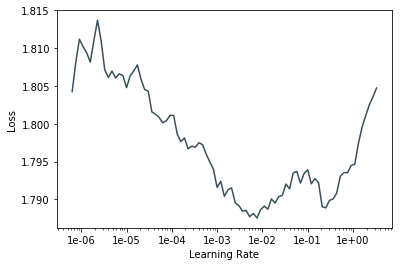

In [14]:
learn_own.recorder.plot()

In [15]:
np.random.seed(42)
learn_own.fit_one_cycle(40, max_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.769283,1.746957,0.307786,00:49
1,1.731092,1.692571,0.351507,00:49
2,1.680690,1.645849,0.381641,00:50
3,1.621313,1.569501,0.399408,00:50
4,1.554621,1.524426,0.422226,00:49
5,1.503523,1.474436,0.429194,00:50
6,1.473058,1.523921,0.406027,00:49
7,1.427257,1.530652,0.411775,00:49
8,1.384556,1.413756,0.450618,00:50
9,1.366153,1.368305,0.478314,00:49


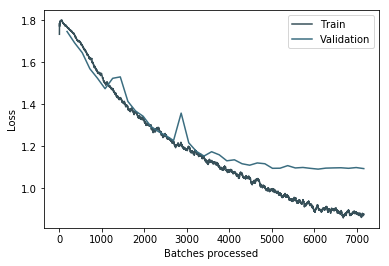

In [16]:
learn_own.recorder.plot_losses()

### *CNN Features*

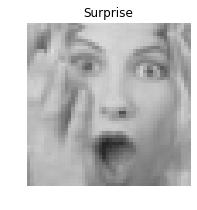

In [133]:
m = learn_own.model.eval()
x,y = data.train_ds[0]
xb,_ = data.one_item(x)
x.show(y=y)

In [125]:
def hooked_backward(y, i):
    with hook_output(m[i]) as hook_a: 
        with hook_output(m[i], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(y)].backward()
    return hook_a,hook_g

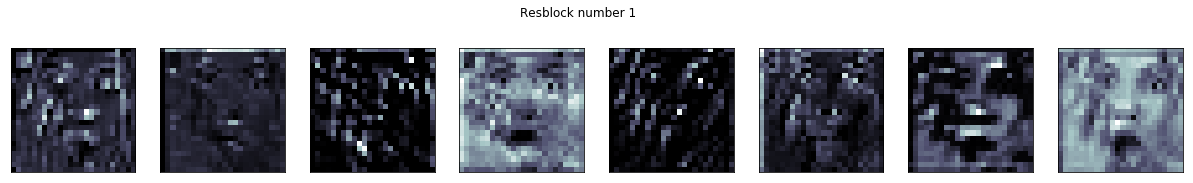

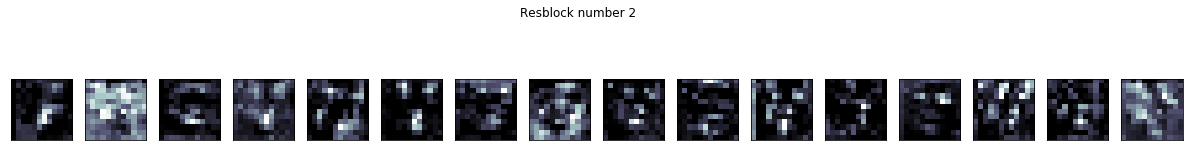

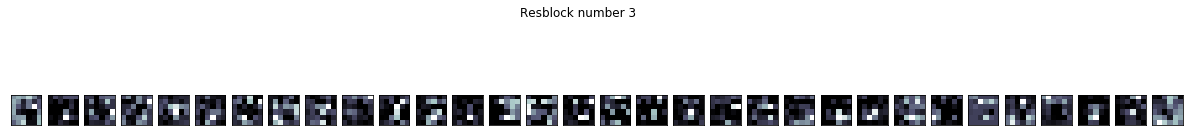

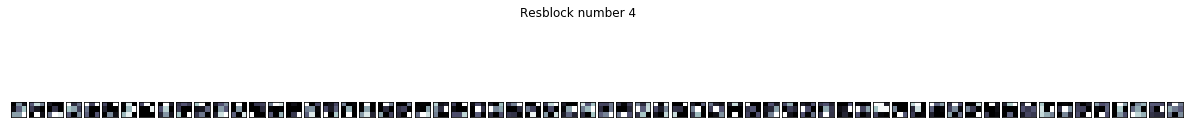

In [134]:
for i in range(4):
    fig = plt.figure(figsize=(21,3))
    fig.suptitle('Resblock number ' + str(i+1))
    hook_a,hook_g = hooked_backward(y, i)
    acts  = hook_a.stored[0]
    for j in range(len(acts)):
        plt.subplot(1,len(acts),j+1, xticks=[], yticks=[],)
        plt.imshow(acts[j], cmap=plt.cm.bone)
plt.show()